# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [20]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [21]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray_data"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VALID ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


# Image Transformation and Load Dataset 

In [22]:
from torchvision import transforms as T, datasets
from helper import show_image

In [23]:
train_transfrom = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406],[0.229, 0.224,0.225])
])
valid_transfrom = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406],[0.229, 0.224,0.225])
])
test_transfrom = T.Compose([
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406],[0.229, 0.224,0.225])
])

In [24]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VALID)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform = train_transfrom)
validset = datasets.ImageFolder(valid_path, transform = valid_transfrom)
testset = datasets.ImageFolder(test_path, transform = test_transfrom)

In [25]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


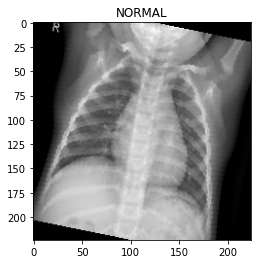

In [26]:
image, label = trainset[2]
class_name = ['NORMAL', 'PNEUMONIA']
show_image(image, class_name[label])

# Load Dataset into Batches 

In [27]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [28]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size = CFG.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size = CFG.batch_size, shuffle=True)

In [29]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


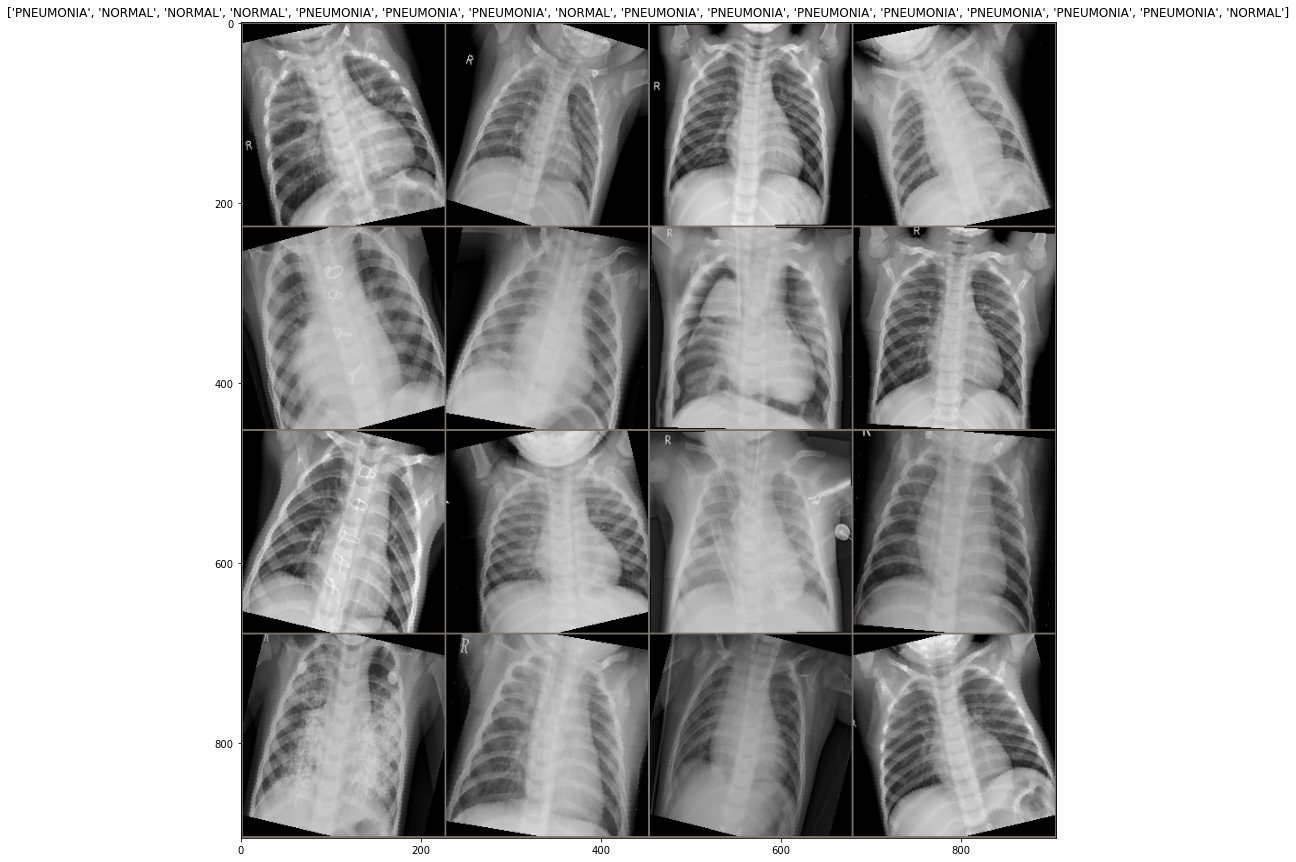

In [30]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
out = make_grid(images, nrow=4)
show_grid(out, title = [class_name[x]for x in labels])

# Fine Tuning EfficientNet Model 

In [31]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained = True)

for param in model.parameters():
    param.requires_grid = False
    
model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p= 0.3),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2),
)


In [32]:
from torchsummary import summary 

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

# Build a Simple Trainer

In [33]:
from helper import accuracy
from tqdm import tqdm

In [39]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        train_acc = 0.0
        train_loss = 0.0
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
        return train_acc/len(trainloader), train_loss/len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        valid_acc = 0.0
        valid_loss = 0.0
        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
        return valid_acc/len(validloader), valid_loss/len(validloader)
            
        
    def fit(self, model,trainloader,validloader,epochs):
        model = model.to(device)
        valid_min_loss = np.Inf
        for i in range(epochs):
            model.train() #turn on dropout
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            model.eval() # turn off droput and batch normaliziation
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            if avg_valid_loss <= valid_min_loss:
                print('valiid loss decreased {}-->{}'.format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
            print('Epoch: {} Train Acc: {}'.format(i+1, avg_train_loss, avg_train_acc))
            print('Epoch: {} Valid Acc: {}'.format(i+1, avg_valid_loss, avg_valid_acc))

# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [40]:
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
schedular = None

trainer = PneumoniaTrainer(criterion, optimizer, schedular)
trainer.fit(model, trainloader, validloader, epochs= CFG.epochs)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


valiid loss decreased inf-->0.20411255955696106
Epoch: 1 Train Acc: 0.09084620788713783
Epoch: 1 Valid Acc: 0.20411255955696106


# Plot Results 

In [41]:
from helper import view_classify
model.load_state_dict(torch.load('ColabPneumoniaModel.pt', map_location = device))

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [17:28<00:00, 26.89s/it]


Test Acc : 0.879807710647583
Test Loss : 0.2958922751056842


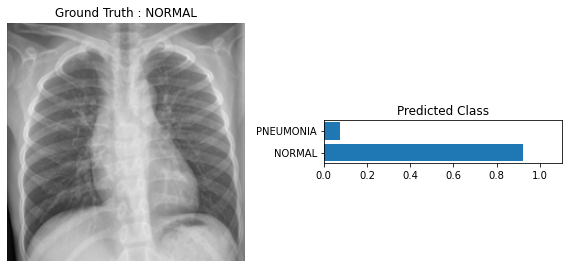

In [42]:
image,label = testset[3]

logits = model(image.unsqueeze(0))
ps = F.softmax(logits,dim = 1)

view_classify(image,ps,label)